# Install Pygame and Atari, then update gym

In [1]:
# Do not install Pygame directly
# Install it using gym[classic_control] for correct versioning

!pip install gym[box2d,accept-rom-license]
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 92 kB/s 
     |████████████████████████████████| 1.8 MB 18.5 MB/s 
     |████████████████████████████████| 374 kB 70.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached libtorrent-2.0.7-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.0-py3-none-any.whl size=440868 sha256=bd8607bf4b5896511bd50a4331a465f301f43e712b83d9c248d81b0a4feb3871
  Stored in directory: /root/.cache/pip/wheels/bf/c9/25/578470ae932b494c313dc22e6c57afff192140fb3cd5acf185
Successfully built AutoROM.accept-rom-license
Failed to build box2d-py
    Running setup.py install for box2d-py ... done
  

# Function to display MP4 files inside Colab

In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(file_name):
    mp4 = open(file_name, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Imports

In [3]:
import random
from collections import deque
import numpy as np

import cv2

import gym

import torch
import torchinfo

import matplotlib.pyplot as plt
import seaborn as sns

(96, 96, 3)


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


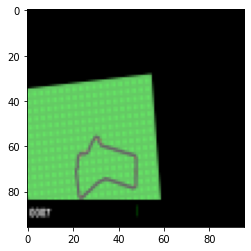

Height: 96, Width: 96


In [4]:
environment = gym.make("CarRacing-v2")

state = environment.reset()
print(state.shape)
plt.imshow(state)
plt.show()
print(f"Height: {state.shape[0]}, Width: {state.shape[1]}")

(84, 84, 3)


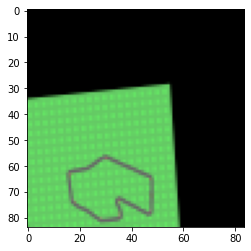

New Height: 84, New Width: 84


In [5]:
def clean_image(image):
    return image[0:84, 0:84]

state = environment.reset()
state = clean_image(state)
print(state.shape)
plt.imshow(state)
plt.show()
print(f"New Height: {state.shape[0]}, New Width: {state.shape[1]}")

Old image size: (96, 96, 3)
New image size: torch.Size([1, 84, 84])


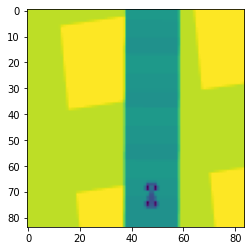

In [6]:
# Optional - Modify the environment's step function so it cleans the state for us
environment = gym.make("CarRacing-v2",domain_randomize=False)

def clean_image(image):
    image = image[0:84, 0:84]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = torch.tensor(image, dtype=torch.float)/255
    image = image[None, None, ...]
    image = torch.nn.functional.interpolate(image, size=(84, 84))
    image = image[0]
    return image

def new_step(step):
    def wrapper(action):
        state, reward, done, *info = step(action)
        state = clean_image(state)
        return state, reward, done, info
    return wrapper

def new_reset(reset):
    def wrapper():
        state = reset()
        state = clean_image(state)
        return state
    return wrapper

# Show the original image shape after a step
print(f"Old image size: {environment.reset().shape}")

# Add our decorator to the step function
environment.step = new_step(environment.step)
environment.reset = new_reset(environment.reset)

# Notice the shape is now different (cleaned)
print(f"New image size: {environment.step(np.array([0, 0, 0]).astype(np.float32))[0].shape}")


steps = 0
done = False
s = environment.reset()
while not done:
    steps += 1
    s, r, done, *_ = environment.step(np.array([0, 0, 0]).astype(np.float32))

plt.imshow(s[0].numpy())
plt.show()


# Neural Network



In [7]:
class ConvolutionalNN(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=(5, 5),
            stride=2,
            bias=False,
        )

        self.conv2 = torch.nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=2,
            bias=False,
        )

       # self.conv3 = torch.nn.Conv2d(
            #in_channels=32,
            #out_channels=32,
            #kernel_size=(3, 3),
            #stride=1,
            #bias=False,
       # )
        
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool_1(x)
        x = torch.nn.functional.relu(x)

        x = self.conv2(x)
        x = self.max_pool_1(x)
        x = torch.nn.functional.relu(x)

        #x = self.conv3(x)
        #x = torch.nn.functional.leaky_relu(x)

        x = self.flatten(x)
        return x


class DenseNN(torch.nn.Module):
    def __init__(self, input_features, action_space):
        super(DenseNN, self).__init__()

        self.linear1 = torch.nn.Linear(input_features, 256)
        self.linear2 = torch.nn.Linear(256, action_space)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)

        x = self.linear2(x)
        return x


class QualityNN(torch.nn.Module):
    def __init__(self, action_space):
        super(QualityNN, self).__init__()

        self.cnn = ConvolutionalNN()
        self.dnn = DenseNN(512, action_space)

    def forward(self, x):
        x = self.cnn(x)
        x = self.dnn(x)
        return x

In [8]:
test_model = QualityNN(action_space=4)
test_state = environment.reset()
test_state = torch.cat((test_state, test_state, test_state))
batched_test_state = test_state.unsqueeze(0)

batched_qualities = test_model(batched_test_state)
qualities = batched_qualities[0]
action = torch.argmax(qualities)

print(f"Qualities: {qualities}")
print(f"Policy: We should greedily take action {action}")
print()

print(torchinfo.summary(test_model, input_size=(1, 3, 84, 84)))

Qualities: tensor([-0.0023, -0.0464, -0.0638,  0.0343], grad_fn=<SelectBackward0>)
Policy: We should greedily take action 3

Layer (type:depth-idx)                   Output Shape              Param #
QualityNN                                [1, 4]                    --
├─ConvolutionalNN: 1-1                   [1, 512]                  --
│    └─Conv2d: 2-1                       [1, 16, 40, 40]           1,200
│    └─MaxPool2d: 2-2                    [1, 16, 20, 20]           --
│    └─Conv2d: 2-3                       [1, 32, 9, 9]             4,608
│    └─MaxPool2d: 2-4                    [1, 32, 4, 4]             --
│    └─Flatten: 2-5                      [1, 512]                  --
├─DenseNN: 1-2                           [1, 4]                    --
│    └─Linear: 2-6                       [1, 256]                  131,328
│    └─Linear: 2-7                       [1, 4]                    1,028
Total params: 138,164
Trainable params: 138,164
Non-trainable params: 0
Total mult-add

# Memory Storage

In [9]:
class Memory(object):
    def __init__(self, max_size=10000):
        self.memory = deque(maxlen=max_size)

    def push(self, element):
        self.memory.append(element)

    def get_batch(self, batch_size=64):
        if batch_size > len(self.memory):
            batch_size = len(self.memory)
        return random.sample(self.memory, batch_size)

    def __repr__(self):
        return f"Current elements in memory: {len(self.memory)}"

    def __len__(self):
        return len(self.memory)

# DQN Agent

In [10]:
class Agent(object):
    def __init__(self, environment):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = QualityNN(action_space=12).to(self.device)
        self.target_model = QualityNN(action_space=12).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-4, momentum=0.9)
        #self.action_space    = [
         #   (-0.8, 0.5, 0.2), (0, 0.5, 0.2), (0.8, 0.5, 0.2), #           Action Space Structure
         #   (-0.8, 0.5,   0), (0, 0.5,   0), (0.8, 0.5,   0), #        (Steering Wheel, Gas, Break)
          #  (-0.8, 0, 0.2), (0, 0, 0.2), (0.8, 0, 0.2), # Range        -1~1       0~1   0~1
          #  (-0.8, 0.5,   0), (0, 0,   0), (0.8, 0,   0)
        #]
        #self.action_space = [(1, 0.3, 0.0), (0.0, 0.8,0.0), (-1, 0.3, 0.0), (0.0, 0.8, 0.3)] 
        self.action_space    = [
            (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2), #           Action Space Structure
            (-1, 1,   0), (0, 1,   0), (1, 1,   0), #        (Steering Wheel, Gas, Break)
            (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2), # Range        -1~1       0~1   0~1
            (-1, 0,   0), (0, 0,   0), (1, 0,   0)
        ]
        self.decay = 0.995
        self.randomness = 1.5
        self.min_randomness = 0.001
        self.update_target()

    def act(self, state):
        # move the state to a Torch Tensor and add a batch of size 1
        
        state = state.to(self.device).unsqueeze(0)

        qualities = self.model(state).cpu()
        qualities = qualities[0]

        if np.random.rand() <= self.randomness:
            action = np.random.randint(low=0, high=qualities.size(dim=0))
        else:
            action = torch.argmax(qualities).item()

        return self.action_space[action]

    def update(self, memory_batch):
        states, next_states, actions, rewards = self.unpack_batch(memory_batch)

        old_targets = self.old_targets(states, actions)
        new_targets = self.new_targets(states, next_states, rewards, actions)
        loss = torch.nn.functional.smooth_l1_loss(old_targets, new_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # return the loss for logging purposes
        return loss.item()

    def old_targets(self, states, actions):
        return self.model(states).gather(1, actions)

    def new_targets(self, states, next_states, rewards, actions):
        return rewards + torch.amax(self.target_model(next_states), dim=1, keepdim=True)

    def unpack_batch(self, batch):
        states, next_states, actions, rewards = zip(*batch)
        new_actions =[]

        states = torch.stack(states).to(self.device)
        next_states = torch.stack(next_states).to(self.device)
        for i in actions:
          new_actions.append(self.action_space.index(i))

        actions = torch.tensor(new_actions).long().unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards).float().unsqueeze(1).to(self.device)

        return states, next_states, actions, rewards

    def update_randomness(self):
        self.randomness *= self.decay
        self.randomness = max(self.randomness, self.min_randomness)

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())




#Double DQN Agent

In [ ]:
class Agent(object):
    def __init__(self, environment):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = QualityNN(action_space=12).to(self.device)
        self.target_model = QualityNN(action_space=12).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-4, momentum=0.9)
        #self.action_space    = [
         #   (-0.8, 0.5, 0.2), (0, 0.5, 0.2), (0.8, 0.5, 0.2), #           Action Space Structure
         #   (-0.8, 0.5,   0), (0, 0.5,   0), (0.8, 0.5,   0), #        (Steering Wheel, Gas, Break)
          #  (-0.8, 0, 0.2), (0, 0, 0.2), (0.8, 0, 0.2), # Range        -1~1       0~1   0~1
          #  (-0.8, 0.5,   0), (0, 0,   0), (0.8, 0,   0)
        #]
        #self.action_space = [(1, 0.3, 0.0), (0.0, 0.8,0.0), (-1, 0.3, 0.0), (0.0, 0.8, 0.3)] 
        self.action_space    = [
            (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2), #           Action Space Structure
            (-1, 1,   0), (0, 1,   0), (1, 1,   0), #        (Steering Wheel, Gas, Break)
            (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2), # Range        -1~1       0~1   0~1
            (-1, 0,   0), (0, 0,   0), (1, 0,   0)
        ]
        self.decay = 0.995
        self.randomness = 1.5
        self.min_randomness = 0.001
        self.update_target()

    def act(self, state):
        # move the state to a Torch Tensor and add a batch of size 1
        
        state = state.to(self.device).unsqueeze(0)

        qualities = self.model(state).cpu()
        qualities = qualities[0]

        if np.random.rand() <= self.randomness:
            action = np.random.randint(low=0, high=qualities.size(dim=0))
        else:
            action = torch.argmax(qualities).item()

        return self.action_space[action]

    def update(self, memory_batch):
        states, next_states, actions, rewards = self.unpack_batch(memory_batch)

        old_targets = self.old_targets(states, actions)
        new_targets = self.new_targets(states, next_states, rewards, actions)
        loss = torch.nn.functional.smooth_l1_loss(old_targets, new_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # return the loss for logging purposes
        return loss.item()

    def old_targets(self, states, actions):
        return self.model(states).gather(1, actions)

    def new_targets(self, states, next_states, rewards, actions):
        max_indices = torch.argmax(self.target_model(next_states), dim=1, keepdim=True)
        return rewards + self.model(next_states).gather(1, max_indices)

    def unpack_batch(self, batch):
        states, next_states, actions, rewards = zip(*batch)
        new_actions =[]

        states = torch.stack(states).to(self.device)
        next_states = torch.stack(next_states).to(self.device)
        for i in actions:
          new_actions.append(self.action_space.index(i))

        actions = torch.tensor(new_actions).long().unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards).float().unsqueeze(1).to(self.device)

        return states, next_states, actions, rewards

    def update_randomness(self):
        self.randomness *= self.decay
        self.randomness = max(self.randomness, self.min_randomness)

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())



# TD Learning

In [11]:
max_iteration = 1500
logging_iteration = 20
update_iteration = 5

# some logging values
score_logging = []
error_logging = []

agent = Agent(environment)
memory = Memory(max_size=10000)
state_stack = deque(maxlen=4)

for iteration in range(1, max_iteration + 1):
    done = False
    state = environment.reset()
    state_stack.append(state)

    # some logging values
    cummulative_reward = 0
    negative_limit = 0
    cummulative_error = 0
    

    # play (do nothing) for 3 frames so we can start frame stacking
    for _ in range(3):
        state, *_ = environment.step((0,0,0))
        state_stack.append(state)

    while not done:
        
        action = agent.act(torch.cat(list(state_stack)[1:]))
        state, reward, done, *_ = environment.step(action)
        state_stack.append(state)
        
        if reward < 0 :
          negative_limit +=1
        

        #if reward > 1 :
          #reward = 1
        cummulative_reward += reward
        #if negative_limit > 80:
          #break
        if cummulative_reward < 0 and negative_limit > 25:
          break

        memory.push(element=(
            torch.cat(list(state_stack)[:-1]),
            torch.cat(list(state_stack)[1:]),
            action,
            reward,
        ))

        

        #cummulative_reward += reward
        #if cummulative_reward < 0 and negative_limit > 5:
          #break

    # make a few learning updates
    if len(memory.memory) >=4 :
      for _ in range(64):
        memory_batch = memory.get_batch(batch_size=128)
        error = agent.update(memory_batch)
        cummulative_error += error
      agent.update_randomness()
    if iteration % update_iteration == 0:
      agent.update_target()
    


    # logging values and printing some
    error_logging.append(cummulative_error/64)
    score_logging.append(cummulative_reward)
    if iteration % logging_iteration == 0:
        print(f"Iteration: {iteration}")
        print(f"  Moving-Average Scores   : {np.mean(np.array(score_logging)[-logging_iteration:])}")
        print(f"  Memory-Buffer Size    : {len(memory.memory)}")
        print(f"  Agent Randomness      : {agent.randomness:.3f}")
        print()


Iteration: 20
  Moving-Average Scores   : -0.9452745727906458
  Memory-Buffer Size    : 734
  Agent Randomness      : 1.357

Iteration: 40
  Moving-Average Scores   : -0.5674804285134382
  Memory-Buffer Size    : 2048
  Agent Randomness      : 1.227

Iteration: 60
  Moving-Average Scores   : -0.5609403434505136
  Memory-Buffer Size    : 3410
  Agent Randomness      : 1.110

Iteration: 80
  Moving-Average Scores   : -0.8274570199904158
  Memory-Buffer Size    : 4029
  Agent Randomness      : 1.004

Iteration: 100
  Moving-Average Scores   : -0.8119936371976492
  Memory-Buffer Size    : 4684
  Agent Randomness      : 0.909

Iteration: 120
  Moving-Average Scores   : -0.8266229687607574
  Memory-Buffer Size    : 5540
  Agent Randomness      : 0.822

Iteration: 140
  Moving-Average Scores   : -0.9414824238220388
  Memory-Buffer Size    : 7152
  Agent Randomness      : 0.744

Iteration: 160
  Moving-Average Scores   : -0.4290390305061356
  Memory-Buffer Size    : 7889
  Agent Randomness    

# Plotting and results

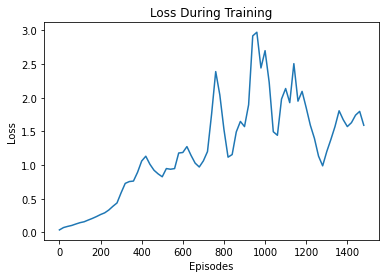

In [12]:
x = np.arange(0, len(error_logging), logging_iteration)
y = np.add.reduceat(error_logging, x) / logging_iteration

plt.plot(x, y)
plt.title("Loss During Training")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

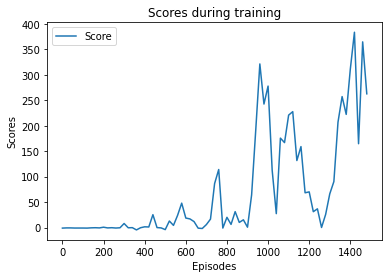

In [13]:
wins = np.array(score_logging)[:]

x = np.arange(0, len(wins), logging_iteration)

y1 = np.add.reduceat(wins, x) / logging_iteration

#x = np.arange(0, len(wins))
#y1 = wins

sns.lineplot(x=x, y=y1, legend="brief", label="Score")
plt.title("Scores during training")
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.show()

# Show some saved videos

In [14]:
max_iteration = 1
logging_iteration = 1

environment = gym.wrappers.RecordVideo(
    gym.make("CarRacing-v2",domain_randomize=False),
    video_folder="./videos",
    episode_trigger=lambda x: x == max_iteration - 1
)

state_stack = deque(maxlen=4)
for iteration in range(1, max_iteration + 1):
    done = False
    state = environment.reset()
    state_stack.append(state)

    # some logging values
    score = 0

    # play (do nothing) for 2 frames so we can start frame stacking
    for _ in range(3):
        state, *_ = environment.step((0,0,0))
        state_stack.append(clean_image(state))

    while not done:
        # Action 2 is up. Action 3 is down
        # Map NN action of 0->2 and action of 1->3
        action = agent.act(torch.cat(list(state_stack)[1:]))
        state, reward, done, *_ = environment.step(action)
        state_stack.append(clean_image(state))
        score += reward

display(show_video(f"./videos/rl-video-episode-0.mp4"))

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprec

In [15]:
score

636.4563517915182